# `CLOUD.jl` - 2D linear advection

In [1]:
using CLOUD
using OrdinaryDiffEq
using LinearAlgebra
using TimerOutputs
plots_path = "../plots/advection_dgmulti_2D/"
results_path = "../results/advection_dgmulti_2D/";

Define the physical problem

In [2]:
θ = π/4
a = sqrt(2)
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L)  # wave number
T = 1.0/(a*max(abs(cos(θ)),abs(cos(θ))))  # end time
initial_data = InitialDataSine(A,k)
conservation_law = linear_advection_equation((a*cos(θ),a*sin(θ)),λ=1.0);

Set up a quadrature-based DG scheme of degree `p` with `M` intervals in each direction

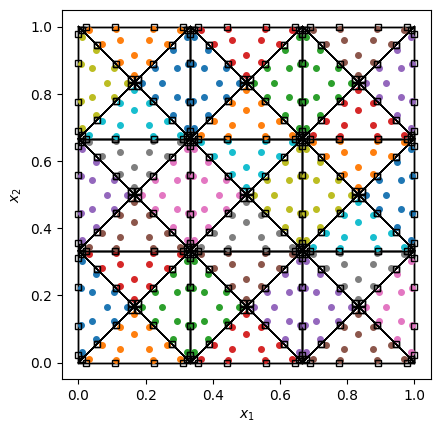

In [3]:
M = 3  # number of elements
p = 3  # degree of discretization
reference_approximation=ReferenceApproximation(
    DGMulti(p), Tri(), N_plot=ceil(Int,50/M));
spatial_discretization = SpatialDiscretization(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    ((0.0,L),(0.0,L)), (M,M), collapsed=true), reference_approximation);
results_path = save_project(conservation_law,
     spatial_discretization, initial_data, WeakConservationForm(), 
     (0.0, T), Lazy(), results_path, overwrite=true, clear=true)
visualize(spatial_discretization, plots_path, "mesh.pdf")

Run the `OrdinaryDiffEq` solver, taking `n_s` snapshots

In [4]:
reset_timer!()
n_s = 10
dt_scale=0.1
dt = dt_scale*(L/M)/(norm(a)*(2*p+1))
ode_problem = semidiscretize(load_project(results_path)...)
save_solution(ode_problem.u0, 0.0, results_path, 0)
sol = solve(ode_problem, RK4(), adaptive=false,
    dt=dt, save_everystep=false,
    callback=save_callback(results_path, ceil(Int, T/(dt*n_s))))
save_solution(last(sol.u), last(sol.t), results_path, "final")
print_timer()

 ──────────────────────────────────────────────────────────────────────────────
                                       Time                   Allocations      
                               ──────────────────────   ───────────────────────
       Tot / % measured:            12.8s / 11.2%           2.28GiB / 28.7%    

 Section               ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────────────────
 rhs!                   1.20k    1.44s   100%  1.20ms    671MiB  100%    573KiB
   eval residual        43.1k    810ms  56.3%  18.8μs    326MiB  48.5%  7.73KiB
     facet terms        43.1k    300ms  20.9%  6.96μs   94.3MiB  14.1%  2.24KiB
     volume terms       43.1k    269ms  18.7%  6.24μs    155MiB  23.1%  3.67KiB
     mass matrix solve  43.1k   61.2ms  4.25%  1.42μs   50.0MiB  7.46%  1.19KiB
   eval numerical flux  43.1k    242ms  16.8%  5.60μs    114MiB  17.0%  2.70KiB
   eval flux            43.1k   77.1ms 

Visualize the solution

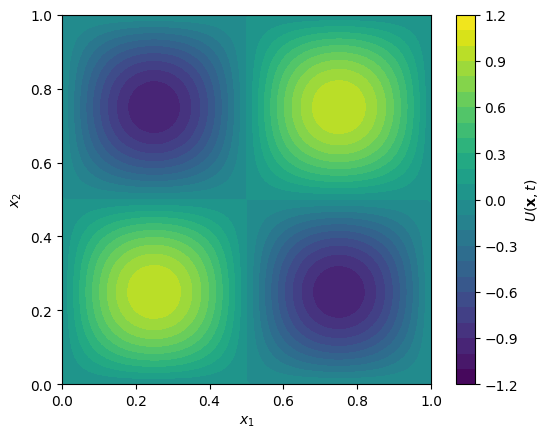

In [5]:
plotter = Plotter(spatial_discretization, plots_path)
visualize(initial_data, plotter, "exact.pdf", u_range=[-1.0,1.0], contours=25,
    label="U(\\mathbf{x},t)")

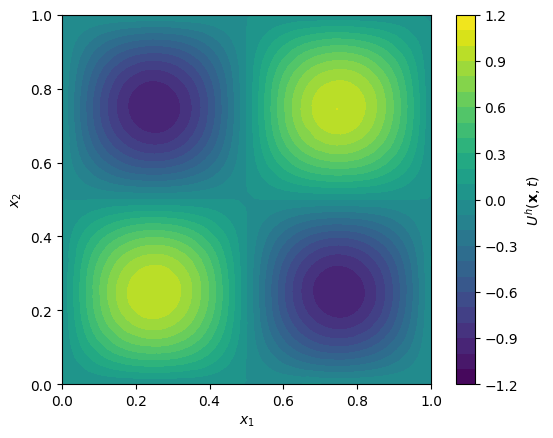

In [6]:
visualize(last(sol.u),plotter, "approx.pdf", contours=25, u_range=[-1.0,1.0],
    label="U^h(\\mathbf{x},t)")

Calculate the integral L<sup>2</sup> error norm and conservation/energy error

In [7]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
println("L2 error:\n", analyze(error_analysis, last(sol.u), initial_data))
println("Conservation (initial/final/diff):\n", analyze(conservation_analysis)...)
println("Energy (initial/final/diff):\n",analyze(energy_analysis)...)

L2 error:
[0.001912893223329703]
Conservation (initial/final/diff):
[2.6020852139652106e-18][8.673617379884035e-19][-1.734723475976807e-18]
Energy (initial/final/diff):
[0.24999960184782694][0.2498357503419475][-0.00016385150587944208]


In [8]:
check_sbp_property(reference_approximation)

(5.861977570020827e-14, 7.242123567507974e-14)